# Final Project: Landslide Exposure of Building Infrastructures in Portland, OR 

Daniel Acosta, 2021  
CEWA 599  
Instructor: David Shean  

## Objective  
* Load raster data of landslide susceptibility (LS) map of Portland, Oregon
* Load the building data of Portland, Oregon
* Load the Portland neighborhood boundaries 
* Compute the LS level for each building
* Compute the landslide exposure as the area of all buildings under different LS levels

## Tools
* GDAL
* Rasterio
* NumPy
* Matplotlib

## Tools

In [2]:
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import rasterstats

/srv/conda/envs/notebook/lib/python3.8/site-packages/rasterio/plot.py:263: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(arr.shape) is 2:


In [3]:
from osgeo import gdal
import rasterio as rio
import rasterio.plot

In [4]:
%matplotlib inline

## Part 1: Loading raster data  
Using Raster basic to open downloaded image from disk

In [5]:
path = r'Portland_LSM.tif'

In [6]:
with rio.open(path) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535.0, 'width': 3196, 'height': 2532, 'count': 1, 'crs': CRS.from_epsg(2994), 'transform': Affine(32.80839896745932, 0.0, 704567.5157,
       0.0, -32.808398933649286, 1431484.1683), 'tiled': False, 'interleave': 'band'}


In [7]:
ls = rio.open(path)

In [8]:
ls.count

1

In [9]:
ls.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 65535.0,
 'width': 3196,
 'height': 2532,
 'count': 1,
 'crs': CRS.from_epsg(2994),
 'transform': Affine(32.80839896745932, 0.0, 704567.5157,
        0.0, -32.808398933649286, 1431484.1683)}

In [10]:
a = ls.read(1)

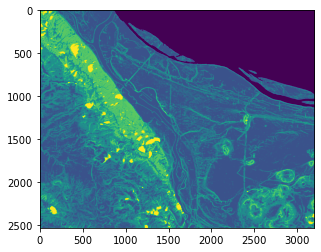

In [11]:
f, ax=plt.subplots()
ax.imshow(a)

### Open raster data into NumPy array

In [12]:
im = gdal.Open(path)
gdal_im = im.GetRasterBand(1)
r = gdal_im.ReadAsArray()
r

array([[3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       ...,
       [2, 2, 2, ..., 3, 2, 2],
       [1, 1, 2, ..., 3, 3, 2],
       [1, 1, 1, ..., 3, 3, 2]], dtype=uint16)

In [13]:
with rio.open(path) as red:
    r1 = red.read(1)
r1

array([[3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       ...,
       [2, 2, 2, ..., 3, 2, 2],
       [1, 1, 2, ..., 3, 3, 2],
       [1, 1, 1, ..., 3, 3, 2]], dtype=uint16)

### Eliminate nondata values

In [14]:
import numpy.ma as ma
mask = ma.masked_equal(r, 0)
mask

masked_array(
  data=[[3, 3, 3, ..., --, --, --],
        [3, 3, 3, ..., --, --, --],
        [3, 3, 3, ..., --, --, --],
        ...,
        [2, 2, 2, ..., 3, 2, 2],
        [1, 1, 2, ..., 3, 3, 2],
        [1, 1, 1, ..., 3, 3, 2]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=0,
  dtype=uint16)

Text(0.5, 1.0, 'Portland Landslide Susceptibility Map')

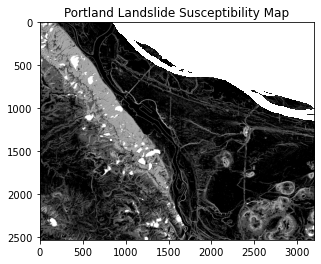

In [15]:
f, ax = plt.subplots()
ax.imshow(mask, cmap = 'gray')
ax.set_title('Portland Landslide Susceptibility Map')

### Histogram of raster data

In [16]:
ls_masked = np.ravel(mask)
ls_masked

masked_array(data=[3, 3, 3, ..., 3, 3, 2],
             mask=[False, False, False, ..., False, False, False],
       fill_value=0,
            dtype=uint16)

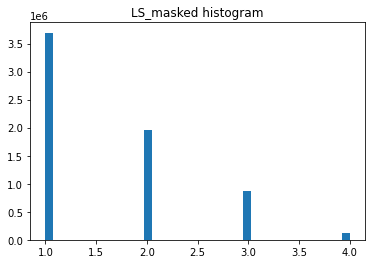

In [17]:
plt.hist(ls_masked, bins = 40)
plt.title('LS_masked histogram')
plt.show()

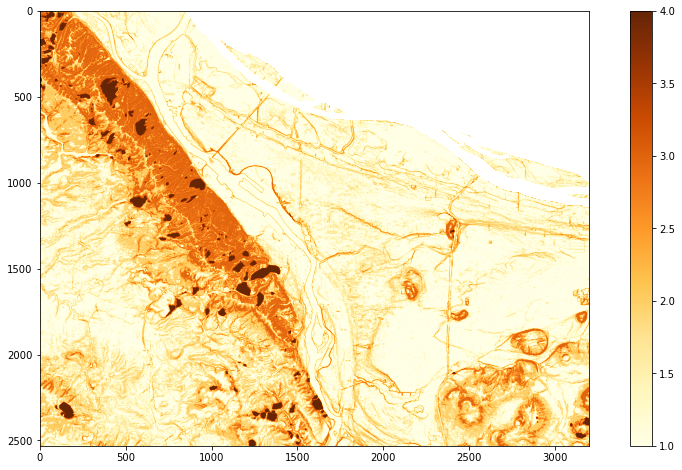

In [18]:
# Plot with coloramp
f, ax = plt.subplots(figsize=(15,8))
lsmap = ax.imshow(mask, cmap='YlOrBr')
f.colorbar(lsmap, ax=ax);

## Part 2: Loading Portland neighborhood boundaries polygons  
Using rasterio to load vector data

In [19]:
%pwd

'/home/jovyan/landslide_exposure_portland/project_data'

In [20]:
neigh = 'portland_neighborhoods_boundaries.gpkg'

In [21]:
n = gpd.read_file(neigh)
n

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,OBJECTID,NAME,COMMPLAN,SHARED,COALIT,HORZ_VERT,Shape_Leng,MAPLABEL,ID,geometry
0,1,LINNTON,None,N,NWNW,HORZ,52741.719772,Linnton,1,"MULTIPOLYGON (((-13672672.739 5717458.926, -13..."
1,2,FOREST PARK/LINNTON,None,Y,NWNW,None,57723.635350,Forest Park/Linnton,2,"MULTIPOLYGON (((-13672615.072 5717458.598, -13..."
2,3,FOREST PARK,None,N,NWNW,HORZ,82725.497522,Forest Park,3,"MULTIPOLYGON (((-13669096.892 5708277.357, -13..."
3,4,CATHEDRAL PARK,None,N,NPNS,HORZ,11434.254777,Cathedral Park,4,"MULTIPOLYGON (((-13666093.373 5714122.821, -13..."
4,5,UNIVERSITY PARK,None,N,NPNS,HORZ,11950.859827,University Park,5,"MULTIPOLYGON (((-13663193.115 5713925.450, -13..."
...,...,...,...,...,...,...,...,...,...,...
125,126,KENTON,ALBINA,N,NPNS,HORZ,19247.188225,Kenton,126,"MULTIPOLYGON (((-13656518.251 5712854.259, -13..."
126,127,BRIDGETON,None,N,NPNS,HORZ,8635.720662,Bridgeton,127,"MULTIPOLYGON (((-13654119.219 5716859.597, -13..."
127,128,EAST COLUMBIA,None,N,NPNS,HORZ,15397.269131,East Columbia,128,"MULTIPOLYGON (((-13654465.933 5716396.064, -13..."
128,129,SUNDERLAND ASSOCIATION OF NEIGHBORS,None,N,CNN,HORZ,20706.496916,Sunderland,129,"MULTIPOLYGON (((-13652256.730 5716663.111, -13..."


In [22]:
n.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

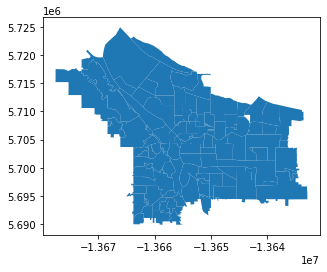

In [23]:
n.plot()

In [24]:
# Define projection AEA for Western US
proj = '+proj=aea +lat_1=34.999455 +lat_2=48.999727 +lat_0=41.999590999999995 +lon_0=-114.267371'

In [25]:
def rio_reproj_write(src, proj_fn, dst_crs, driver='GTiff'):
    #Check to see if output filename already exists
    if os.path.exists(proj_fn):
        print("File exists: ", proj_fn)
    else:
        #Get the required transformation and output width and height
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        #Create a copy of input metadata, then update with output values
        kwargs = src.meta.copy()
        print("Source metadata:\n", kwargs)
        kwargs.update({'crs':dst_crs,'transform':transform,'width':width,'height':height})
        kwargs['driver'] = driver
        #Set output creation options
        kwargs['compress'] = 'LZW'
        kwargs['tiled'] = True
        kwargs['BIGTIFF'] = 'IF_SAFER'
        print("Destination metadata:\n", kwargs)

        #Open the destination dataset in write mode
        with rio.open(proj_fn, 'w', **kwargs) as dst:
            print("Writing: ", proj_fn)
            #Loop through each input band
            for i in range(1, src.count + 1):
                #Reproject!
                reproject(source=rio.band(src, i), destination=rio.band(dst, i), src_transform=src.transform,\
                          src_crs=src.crs, dst_transform=transform, dst_crs=dst_crs, resampling=Resampling.cubic)
            print("Complete")

In [26]:
src = rio.open(path)
proj_fn = os.path.splitext(path)[0]+'_utm_riowarp.tif'
rio_reproj_write(src, proj_fn, proj)

File exists:  Portland_LSM_utm_riowarp.tif


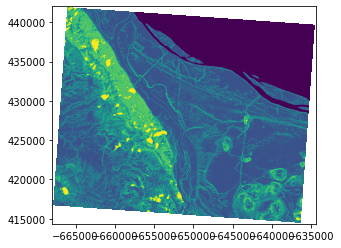

In [27]:
with rio.open(proj_fn) as src_proj:
    rio.plot.show(src_proj)

In [28]:
#Load as a masked array
src_proj = rio.open(proj_fn)
ls_proj = src_proj.read(1, masked=True)

In [29]:
# Getting extent of masked raster array
ls_extent = rio.plot.plotting_extent(src_proj)

<AxesSubplot:>

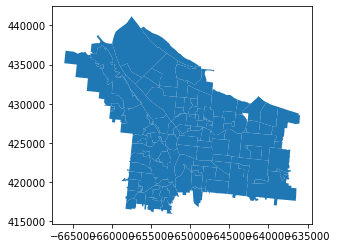

In [30]:
# Reprojecting neighborhood boundaries
n_rp = n.to_crs(proj)

# Plotting
n_rp.plot()

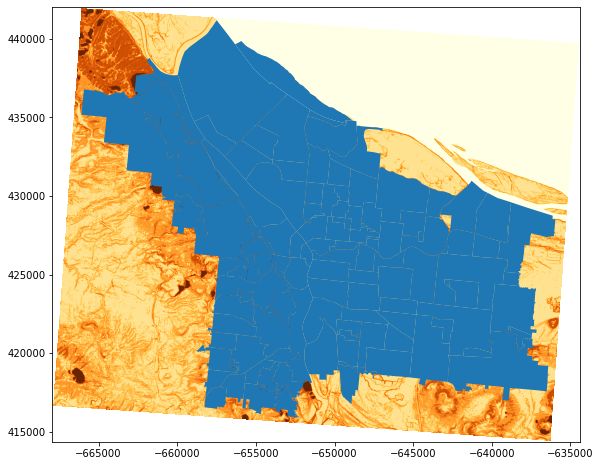

In [31]:
f, ax = plt.subplots(figsize=(15,8))
ax.imshow(ls_proj, cmap='YlOrBr', extent=ls_extent)
n_rp.plot(ax=ax);

In [32]:
# Geometry variable
po_geom = n_rp.geometry
po_geom

0      MULTIPOLYGON (((-662543.186 436406.621, -66251...
1      MULTIPOLYGON (((-662503.227 436402.413, -66249...
2      MULTIPOLYGON (((-660700.674 429737.936, -66077...
3      MULTIPOLYGON (((-658212.026 433621.397, -65850...
4      MULTIPOLYGON (((-656213.977 433284.861, -65597...
                             ...                        
125    MULTIPOLYGON (((-651657.194 432081.004, -65192...
126    MULTIPOLYGON (((-649719.500 434719.891, -64932...
127    MULTIPOLYGON (((-649991.577 434419.210, -64994...
128    MULTIPOLYGON (((-648441.257 434456.601, -64839...
129    MULTIPOLYGON (((-653842.241 433138.803, -65392...
Name: geometry, Length: 130, dtype: geometry

In [33]:
# Clip for Portland Nieghborhoods
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
po_ma, po_ma_transform = rio.mask.mask(src_proj, po_geom, **rio_mask_kwargs)

In [34]:
po_ma.shape

(2531, 3019)

In [35]:
po_ma_transform

Affine(9.983754460045162, 0.0, -666094.3467535608,
       0.0, -9.983754460045162, 441173.58416498365)

In [36]:
#Get clipped extent in UTM coordaintes
po_ma_extent = rio.plot.plotting_extent(po_ma, po_ma_transform)
po_ma_extent

(-666094.3467535608,
 -635953.3920386845,
 415904.70162660937,
 441173.58416498365)

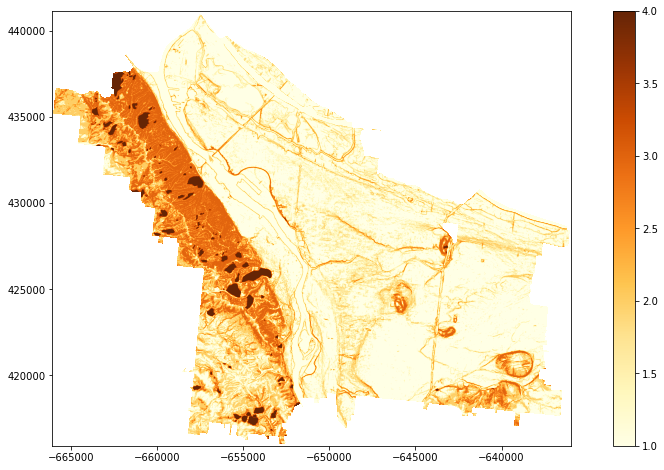

In [37]:
f, ax = plt.subplots(figsize=(15,8))
po_map = ax.imshow(po_ma, extent=po_ma_extent, cmap = 'YlOrBr', vmin=1, vmax=4)
f.colorbar(po_map, ax=ax);

## Part 3: Loading building footprint

In [38]:
bfoot = 'portland_building_footprint.gpkg'

In [39]:
b = gpd.read_file(bfoot)
b

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,OBJECTID,BLDG_ID,STATE_ID,BLDG_NUMB,BLDG_STAT,BLDG_NAME,BLDG_ADDR,BLDG_TYPE,BLDG_USE,BLDG_SQFT,...,ORIENT,VOLUME,Shape_Leng,Shape_Area,PROPKEY,EDIT_STAT,DATA_SOURC,RETIRED_BY,RETIRED_DA,geometry
0,80,1N1W01DA-7900-B1,1N1W01DA 7900,1.0,EXISTING,8135 N OLYMPIA ST,8135 N OLYMPIA ST,House,Single Family Residential,1324.0,...,NaN,24408.0,82.255414,310.967219,653404.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13664023.843 5716110.710, -13..."
1,82,1N1E07CA-7800-B2,1N1E07CA 7800,2.0,EXISTING,6711 N AMHERST ST,6711 N AMHERST ST,Garage,Single Family Residential,554.0,...,NaN,4875.0,44.618188,121.956227,653406.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13663140.644 5713654.765, -13..."
2,89,1N1W01CB-3200-B1,1N1W01CB 3200,1.0,EXISTING,9665 N KELLOGG ST,9665 N KELLOGG ST,House,Single Family Residential,1384.0,...,120.763000,19414.0,81.154237,300.281235,653413.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13665539.575 5715962.379, -13..."
3,163,2N1W26-800-B21,2N1W26 800,21.0,EXISTING,14400 N RIVERGATE BLVD,14400 N RIVERGATE BLVD,None,Single Family Residential,2325.0,...,71.388298,51175.0,84.873482,442.060692,653488.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13668087.946 5720924.525, -13..."
4,176,1N1W01BD-5800-B1,1N1W01BD 5800,1.0,EXISTING,10016 N JAMES ST,10016 N JAMES ST,House,Single Family Residential,688.0,...,-159.205002,15177.0,63.291208,205.587118,653501.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13665270.868 5716671.006, -13..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247195,243684,1N1E11CB-400-B3,1N1E11CB 400,3.0,EXISTING,None,None,None,None,NaN,...,NaN,NaN,16.477285,15.423422,1322707.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13654344.664 5713553.735, -13..."
247196,243685,1N1E11CB-400-B4,1N1E11CB 400,4.0,EXISTING,None,None,None,None,NaN,...,NaN,NaN,16.449943,15.588061,1322708.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13654312.691 5713629.369, -13..."
247197,243686,1N1E11CB-400-B5,1N1E11CB 400,5.0,EXISTING,None,None,None,None,NaN,...,NaN,NaN,16.450143,15.588337,1322709.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13654452.826 5713687.854, -13..."
247198,243687,1N1E11CB-400-B6,1N1E11CB 400,6.0,EXISTING,None,None,None,None,NaN,...,NaN,NaN,16.449627,15.587336,1322710.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13654451.532 5713598.745, -13..."


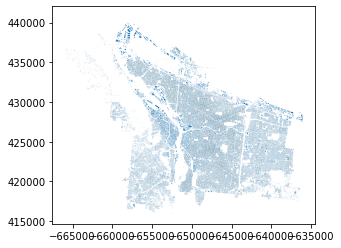

In [40]:
# Reprojecting polygons
b_rp = b.to_crs(proj)
b_rp.plot();

In [42]:
# Plot of all data
%matplotlib widget
f, ax = plt.subplots(figsize=(15,8))
po_map = ax.imshow(po_ma, extent=po_ma_extent, cmap = 'YlOrBr', vmin=1, vmax=4)
f.colorbar(po_map, ax=ax)
n_bound = n_rp.plot(ax=ax, facecolor='None', edgecolor='k', alpha=0.5, lw=0.5)
build = b_rp.plot(ax=ax, alpha=0.5)
ax.set_title('Portland LSM and Building Footprint Map');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Part IV: Statistics applied to Building Footprint  
* Count number of polygons
* Explore the "BLDG_USE" column and create new DataFrame for each
* Calculate the area of the polygons
* ...

In [72]:
b_rp.shape

(247200, 43)

In [66]:
sfr_idx = b_rp['BLDG_USE']=='Single Family Residential'
len(b_use_sfr)

223162

In [67]:
b_rp[~sfr_idx]

,OBJECTID,BLDG_ID,STATE_ID,BLDG_NUMB,BLDG_STAT,BLDG_NAME,BLDG_ADDR,BLDG_TYPE,BLDG_USE,BLDG_SQFT,...,ORIENT,VOLUME,Shape_Leng,Shape_Area,PROPKEY,EDIT_STAT,DATA_SOURC,RETIRED_BY,RETIRED_DA,geometry
97,3160,1N1W01AC-7000-B5,1N1W01AC 7000,5.0,EXISTING,9457 N BRISTOL AVE,9457 N BRISTOL AVE,Apartment Complex,Multi Family Residential,4801.0,...,-147.264008,65442.0,167.466408,910.854747,667567.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-657206.780 435092.166, -65720..."
102,3348,1N1W02DA-7200-B1,1N1W02DA 7200,1.0,EXISTING,9712-9724 N EDISON ST,9712-9724 N EDISON ST,Duplex,Multi Family Residential,3020.0,...,-150.725006,28838.0,77.472361,285.440784,667757.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-658121.658 434737.617, -65812..."
105,3422,1N1W13DC-500-B1,1N1W13DC 500,1.0,EXISTING,6021 NW 60TH AVE,6021 NW 60TH AVE,Duplex,Multi Family Residential,3367.0,...,NaN,31856.0,74.369329,319.858534,682448.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-657217.981 431197.495, -65721..."
132,4193,1N1W01AB-900-B5,1N1W01AB 900,5.0,EXISTING,8732-8778 N COLUMBIA BLVD,8732-8778 N COLUMBIA BLVD,Apartment Complex,Multi Family Residential,2784.0,...,98.746201,15571.0,116.154005,528.670379,667930.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-656980.747 435463.529, -65698..."
174,5216,1N1W01CB-7500-B1,1N1W01CB 7500,1.0,EXISTING,9827 N JERSEY ST,9827 N JERSEY ST,Multiplex,Multi Family Residential,2985.0,...,-62.235600,45208.0,103.539271,564.981863,668296.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-657847.953 434971.645, -65783..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247195,243684,1N1E11CB-400-B3,1N1E11CB 400,3.0,EXISTING,None,None,None,None,NaN,...,NaN,NaN,16.477285,15.423422,1322707.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-650101.477 432423.007, -65009..."
247196,243685,1N1E11CB-400-B4,1N1E11CB 400,4.0,EXISTING,None,None,None,None,NaN,...,NaN,NaN,16.449943,15.588061,1322708.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-650074.133 432473.752, -65007..."
247197,243686,1N1E11CB-400-B5,1N1E11CB 400,5.0,EXISTING,None,None,None,None,NaN,...,NaN,NaN,16.450143,15.588337,1322709.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-650167.354 432524.151, -65016..."
247198,243687,1N1E11CB-400-B6,1N1E11CB 400,6.0,EXISTING,None,None,None,None,NaN,...,NaN,NaN,16.449627,15.587336,1322710.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-650172.540 432461.729, -65016..."


In [70]:
b_rp['BLDG_USE'].value_counts()

Single Family Residential    223162
Multi Family Residential      16297
Not Set                         707
Commercial Office               628
Industrial                      528
Commercial Retail               384
Institutional                   159
Commercial Restaurant           134
Parking                         110
Vacant                           87
Commercial Hotel                 54
Institutional Religious          36
Commercial General                6
Commercial Grocery                3
TOWNHOUSE                         1
Name: BLDG_USE, dtype: int64

In [71]:
b_rp['BLDG_TYPE'].value_counts()

House                       144521
Garage                       42301
Apartment Complex             7442
Duplex                        4943
Unknown                       3110
Residential Condominiums      2468
Not Set                        911
Multiplex                      889
Storage Tank                   293
Dormitories                    116
Commercial Building             15
Building                        14
Townhouse                       10
Mixed Use                        6
Commercial/ Industrial           3
Apartments                       3
Condos                           1
Tool Shed                        1
Condo Tower                      1
Greenhouse                       1
Compressor Building              1
Name: BLDG_TYPE, dtype: int64